# Предсказание погоды

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib inline

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
tf.random.set_seed(0)

## Готовим данные

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [5]:
df = pd.read_csv(csv_path).rename(columns={
    'Date Time': 'datetime',
    'p (mbar)': 'p', 
    'T (degC)': 'T', 
    'rho (g/m**3)': 'h'
})
df = df[['datetime', 'p', 'T', 'h']]
df.datetime = pd.to_datetime(df.datetime)

In [6]:
df.head()

,datetime,p,T,h
0,2009-01-01 00:10:00,996.52,-8.02,1307.75
1,2009-01-01 00:20:00,996.57,-8.41,1309.80
2,2009-01-01 00:30:00,996.53,-8.51,1310.24
3,2009-01-01 00:40:00,996.51,-8.31,1309.19
4,2009-01-01 00:50:00,996.51,-8.27,1309.00


In [7]:
print(f'{df.datetime.dt.date.nunique()} дней')
print(f'{df.shape[0]} записей')

2921 дней
420551 записей


Описание данных
* температура, давление и влажность брались каждые 10 минут
* данные брались с 2009 до 2016 года включительно

## Одномерные данные

Будем предсказывать и использовать только температуру.

In [111]:
from predictor import UnivariateTsPredictor
from data import make_univariate_split, sample_tasks

x_train, y_train, x_val, y_val = make_univariate_split(df)

upred = UnivariateTsPredictor(input_shape=x_train.shape[-2:])

In [112]:
upred.train(x_train, y_train, x_val, y_val)

Epoch 1/10
500/500 [==============================] - 2s 5ms/step - loss: 0.2284 - val_loss: 0.0329
Epoch 2/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0387 - val_loss: 0.0238
Epoch 3/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0308 - val_loss: 0.0216
Epoch 4/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0254 - val_loss: 0.0188
Epoch 5/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0231 - val_loss: 0.0170
Epoch 6/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0205 - val_loss: 0.0157
Epoch 7/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0187 - val_loss: 0.0141
Epoch 8/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0178 - val_loss: 0.0133
Epoch 9/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0164 - val_loss: 0.0127
Epoch 10/10
500/500 [==============================] - 2s 4ms/step - loss: 0.0167 - val_loss: 0.0127

In [113]:
print('Loss: %.1f' % np.abs(upred.model.predict(x_val).reshape(-1)-y_val).sum())

Loss: 1862.5


In [114]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

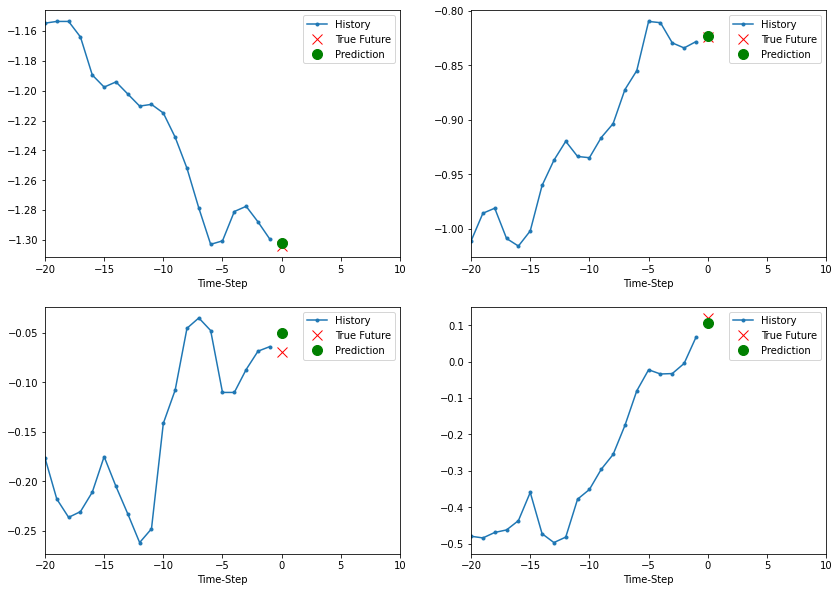

In [139]:
plt.figure(figsize=(14, 10))

for i, (history, target) in enumerate(zip(*sample_tasks(x_val, y_val, k=4, seed=22))):
    plt.subplot(2, 2, i+1)
    show_plot([history.reshape(-1), target, upred.predict(history)], 0, '')
plt.savefig('singledim_singlestep.png')
plot.show()

#### Линейная экстраполяция

In [13]:
from sklearn.linear_model import Ridge
from tqdm.notebook import tqdm

def extrapolate(hist, extrap_len=5):
    hist = hist.reshape(-1)
    time = np.array(list(range(len(hist)))).reshape(-1, 1)
    t = len(hist)
    return Ridge().fit(time[-extrap_len:], hist[-extrap_len:]).predict([[t]])[0]

In [14]:
hour_extrap = []
two_hours_extrap = []
full_extrap = []
for x in tqdm(x_val):    
    hour_extrap.append(extrapolate(x, extrap_len=6))
    two_hours_extrap.append(extrapolate(x, extrap_len=12))
    full_extrap.append(extrapolate(x, extrap_len=20))
hour_extrap = np.array(hour_extrap)
two_hours_extrap = np.array(two_hours_extrap)
full_extrap = np.array(full_extrap)

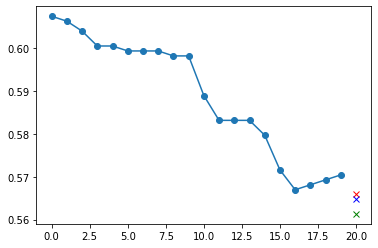

In [15]:
i = 15
plt.plot(list(range(len(x_val[i]))), x_val[i], '-o')
plt.plot(len(x_val[i]), hour_extrap[i], 'rx', color='red')
plt.plot(len(x_val[i]), two_hours_extrap[i], 'rx', color='green')
plt.plot(len(x_val[i]), full_extrap[i], 'rx', color='blue')

In [16]:
print("1 hour: %.1f" % np.abs(hour_extrap - y_val).sum())
print("2 hours: %.1f" % np.abs(two_hours_extrap - y_val).sum())
print("full extrapolation: %.1f" % np.abs(full_extrap - y_val).sum())

1 hour: 2601.2
2 hours: 3629.5
full extrapolation: 5261.2


In [17]:
print("last point duplication: %.1f" % np.abs(x_val.reshape((-1, 20))[:, -1] - y_val).sum())

last point duplication: 2232.2


In [18]:
print("mean historical temperature: %.1f" % np.abs(x_val.reshape((-1, 20)).mean(axis=1) - y_val).sum())

mean historical temperature: 14985.5


## Многомерные данные

In [21]:
from predictor import MultivariateTsPredictor
from data import make_multivariate_split

x_train, y_train, x_val, y_val = make_multivariate_split(df, single_step=True)

mpred = MultivariateTsPredictor(input_shape=x_train.shape[-2:])

In [22]:
mpred.train(x_train, y_train, x_val, y_val)

Epoch 1/10
500/500 [==============================] - 6s 13ms/step - loss: 0.2992 - val_loss: 0.2652
Epoch 2/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2474 - val_loss: 0.2349
Epoch 3/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2442 - val_loss: 0.2311
Epoch 4/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2486 - val_loss: 0.2283
Epoch 5/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2332 - val_loss: 0.2304
Epoch 6/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2427 - val_loss: 0.2399
Epoch 7/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2302 - val_loss: 0.2450
Epoch 8/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2350 - val_loss: 0.2469
Epoch 9/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2310 - val_loss: 0.2275
Epoch 10/10
500/500 [==============================] - 6s 12ms/step - loss: 0.2303 - val_lo

In [59]:
print('loss: %.1f' % np.abs(mpred.model.predict(x_val).reshape(-1)-y_val).sum())

loss: 31313.0


In [68]:
print('repeat a day ago: %.1f' % np.abs(x_val[:, -12, 1] - y_val).sum())

indices = list(i for i in range(84, 120, 24))
print('mean of 2 last days: %.1f' % np.abs(x_val[:, indices, 1].mean(axis=1) - y_val).sum())

indices = list(i for i in range(60, 120, 24))
print('mean of 3 last days: %.1f' % np.abs(x_val[:, indices, 1].mean(axis=1) - y_val).sum())

indices = list(i for i in range(12, 120, 24))
print('mean of 5 last days: %.1f' % np.abs(x_val[:, indices, 1].mean(axis=1) - y_val).sum())

repeat a day ago: 35892.5
mean of 2 last days: 38404.1
mean of 3 last days: 39775.1
mean of 5 last days: 42811.0


In [67]:
print('mean: %.1f' % np.abs(x_val[:, :, 1].mean(axis=1) - y_val).sum())

mean: 49724.0


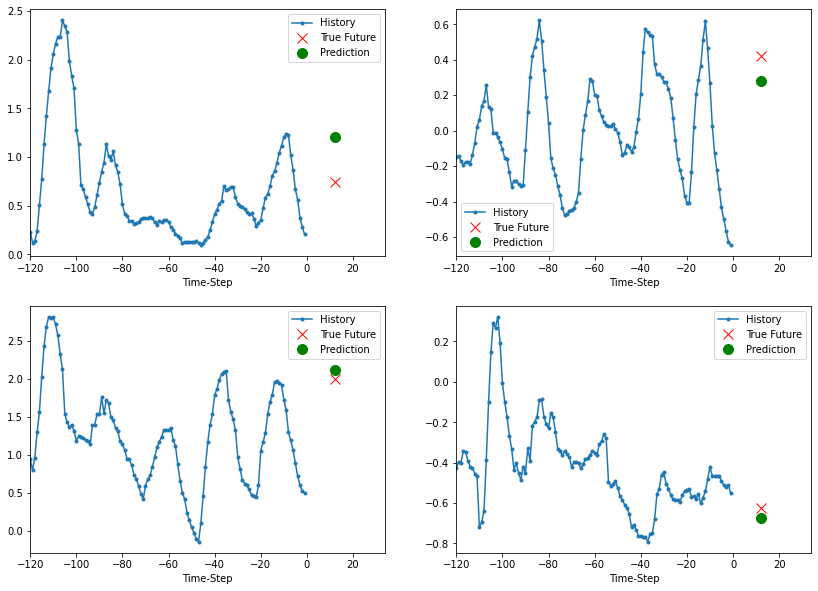

In [105]:
plt.figure(figsize=(14, 10))

for i, (history, target) in enumerate(zip(*sample_tasks(x_val, y_val, k=4, seed=19))):
    plt.subplot(2, 2, i+1)
    show_plot([history[:, 1], target, mpred.predict(history)], 12, '')
plt.savefig('multidim_singlestep.png')
plot.show()

# Предсказание нескольких шагов

In [140]:
from predictor import MultivariateMultistepTsPredictor
from data import make_multivariate_split

x_train, y_train, x_val, y_val = make_multivariate_split(df)

mmpred = MultivariateMultistepTsPredictor(input_shape=x_train.shape[-2:])

In [141]:
mmpred.train(x_train, y_train, x_val, y_val)

Epoch 1/10
500/500 [==============================] - 83s 165ms/step - loss: 95126.5938 - val_loss: 0.2909
Epoch 2/10
500/500 [==============================] - 82s 164ms/step - loss: 0.2370 - val_loss: 0.1974
Epoch 3/10
500/500 [==============================] - 75s 150ms/step - loss: 0.2089 - val_loss: 0.2102
Epoch 4/10
500/500 [==============================] - 74s 149ms/step - loss: 0.2011 - val_loss: 0.1918
Epoch 5/10
500/500 [==============================] - 74s 148ms/step - loss: 0.1867 - val_loss: 0.1877
Epoch 6/10
500/500 [==============================] - 74s 148ms/step - loss: 0.1898 - val_loss: 0.1942
Epoch 7/10
500/500 [==============================] - 77s 153ms/step - loss: 0.1782 - val_loss: 0.1911
Epoch 8/10
500/500 [==============================] - 74s 147ms/step - loss: 0.1809 - val_loss: 0.1910
Epoch 9/10
500/500 [==============================] - 74s 148ms/step - loss: 0.1752 - val_loss: 0.1828
Epoch 10/10
500/500 [==============================] - 71s 143ms/step

In [260]:
def multi_step_plot(history, true_future, prediction, step=6):
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/step, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/step, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')

In [143]:
history, target = sample_tasks(x_val, y_val, k=1)

In [211]:
def predict_with_means(t):
    th = [np.mean(t[range(i, 120, 24)]) for i in range(12)]
    t0 = t[-1]
    result = []
    for t1 in th:
        result.extend([t0 + (t1 - t0) * i / 6 for i in range(6)])
        t0 = t1
    return result

mean_pred = np.array([
    predict_with_means(t) for t in x_val[:, :, 1]
])

In [212]:
mean_pred.shape

(119759, 72)

In [219]:
preds = mmpred.model.predict(x_val)

In [268]:
print('loss: %.1f' % np.abs(preds - y_val).sum())

loss: 1717506.2


In [269]:
print('mean of past days + lin. interpolation: %.1f' % np.abs(mean_pred - y_val).sum())

mean of past days + lin. interpolation: 3011695.8


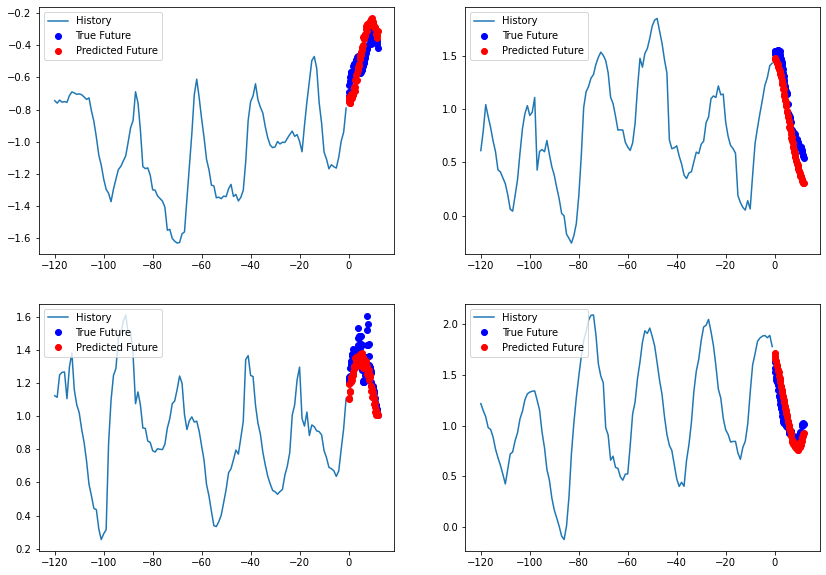

In [267]:
plt.figure(figsize=(14, 10))
for i, (history, target) in enumerate(zip(*sample_tasks(x_val, y_val, k=4, seed=20))):
    plt.subplot(2, 2, i+1)
    multi_step_plot(history, target, mmpred.predict(history))
plt.savefig('multidim_multistep.png')